<a href="https://colab.research.google.com/github/nahidhasan0004/Final-/blob/main/FInal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

import pandas as pd


In [2]:
file='/content/MONTHLY-WINTER.csv'

In [3]:
df = pd.read_csv(file)

df.info(),df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134 entries, 0 to 133
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   YEAR     134 non-null    object 
 1   MAX_AVG  134 non-null    float64
 2   MIN_AVG  134 non-null    float64
 3   RH_AVG   134 non-null    float64
dtypes: float64(3), object(1)
memory usage: 4.3+ KB


(None,
         YEAR   MAX_AVG   MIN_AVG    RH_AVG
 0   1/1/1981  25.11935  13.31290  70.15625
 1   1/2/1981  26.94800  15.41852  67.31034
 2  1/12/1981  25.52333  13.59032  71.15625
 3   1/1/1982  26.27097  12.25000  68.28125
 4   1/2/1982  27.28571  14.98929  62.75862)

In [4]:
df["YEAR"] = pd.to_datetime(df["YEAR"], format="%d/%m/%Y")
df = df.set_index("YEAR").sort_index()
df.head()

,MAX_AVG,MIN_AVG,RH_AVG
YEAR,,,
1981-01-01,25.11935,13.31290,70.15625
1981-02-01,26.94800,15.41852,67.31034
1981-12-01,25.52333,13.59032,71.15625
1982-01-01,26.27097,12.25000,68.28125
1982-02-01,27.28571,14.98929,62.75862


In [15]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler



In [7]:
# Prepare the dataset for modeling
df["YEAR_NUM"] = df.index.year  # Extract numerical year
df["MONTH_NUM"] = df.index.month  # Extract numerical month
X = df[["YEAR_NUM", "MONTH_NUM"]]
y_max = df["MAX_AVG"]
y_min = df["MIN_AVG"]
y_rh = df["RH_AVG"]



In [8]:
# Split the data into training and testing sets
X_train, X_test, y_max_train, y_max_test = train_test_split(X, y_max, test_size=0.2, random_state=42)
_, _, y_min_train, y_min_test = train_test_split(X, y_min, test_size=0.2, random_state=42)
_, _, y_rh_train, y_rh_test = train_test_split(X, y_rh, test_size=0.2, random_state=42)



In [20]:
# Define models
models = {
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42),
}
# Function to create and fit SVR model
def fit_svr(X_train, y_train):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    svr = SVR(kernel='rbf')
    svr.fit(X_train_scaled, y_train)
    return svr, scaler
# Train models and store predictions
predictions = {}
future_years_months = pd.DataFrame({
    "YEAR_NUM": np.tile(np.arange(2023, 2046), 3),  # Repeating years for the 3 months
    "MONTH_NUM": np.tile([1, 2, 12], len(np.arange(2023, 2046)))  # Only Jan (1), Feb (2), and Dec (12)
})

for name, model in models.items():
    model.fit(X_train, y_max_train)
    predictions[f"{name}_MAX"] = model.predict(future_years_months)

    model.fit(X_train, y_min_train)
    predictions[f"{name}_MIN"] = model.predict(future_years_months)

    model.fit(X_train, y_rh_train)
    predictions[f"{name}_RH"] = model.predict(future_years_months)
# SVR
svr_max, scaler_max = fit_svr(X_train, y_max_train)
X_future_scaled = scaler_max.transform(future_years_months[["YEAR_NUM", "MONTH_NUM"]])
predictions["SVR_MAX"] = svr_max.predict(X_future_scaled)

svr_min, scaler_min = fit_svr(X_train, y_min_train)
X_future_scaled = scaler_min.transform(future_years_months[["YEAR_NUM", "MONTH_NUM"]])
predictions["SVR_MIN"] = svr_min.predict(X_future_scaled)

svr_rh, scaler_rh = fit_svr(X_train, y_rh_train)
X_future_scaled = scaler_rh.transform(future_years_months[["YEAR_NUM", "MONTH_NUM"]])
predictions["SVR_RH"] = svr_rh.predict(X_future_scaled)
# Create forecast DataFrame
forecast_df = pd.DataFrame({"YEAR": future_years_months["YEAR_NUM"], "MONTH": future_years_months["MONTH_NUM"]})
for key, values in predictions.items():
    forecast_df[key] = values

# Display forecast for each year from 2023 to 2045, for Jan, Feb, and Dec
forecast_df = forecast_df[forecast_df["YEAR"].between(2023, 2045)]  # Filtering for 2023 to 2045
forecast_df = forecast_df.sort_values(by=["YEAR", "MONTH"])  # Sorting by year and month

# Display the forecasted values in a neat format
print(forecast_df)

    YEAR  MONTH  RandomForest_MAX  RandomForest_MIN  RandomForest_RH  \
0   2023      1         25.390222         15.293305        71.716562   
46  2023      2         27.780628         16.173627        62.071495   
23  2023     12         27.221140         18.093072        73.710544   
24  2024      1         25.390222         15.293305        71.716562   
1   2024      2         27.780628         16.173627        62.071495   
..   ...    ...               ...               ...              ...   
67  2044      2         27.780628         16.173627        62.071495   
44  2044     12         27.221140         18.093072        73.710544   
45  2045      1         25.390222         15.293305        71.716562   
22  2045      2         27.780628         16.173627        62.071495   
68  2045     12         27.221140         18.093072        73.710544   

    XGBoost_MAX  XGBoost_MIN  XGBoost_RH    SVR_MAX    SVR_MIN     SVR_RH  
0     25.147543    15.338550   71.849434  26.710046  15.285

In [21]:
forecast_df.to_csv("forecast_2023_to_2045.csv", index=False)



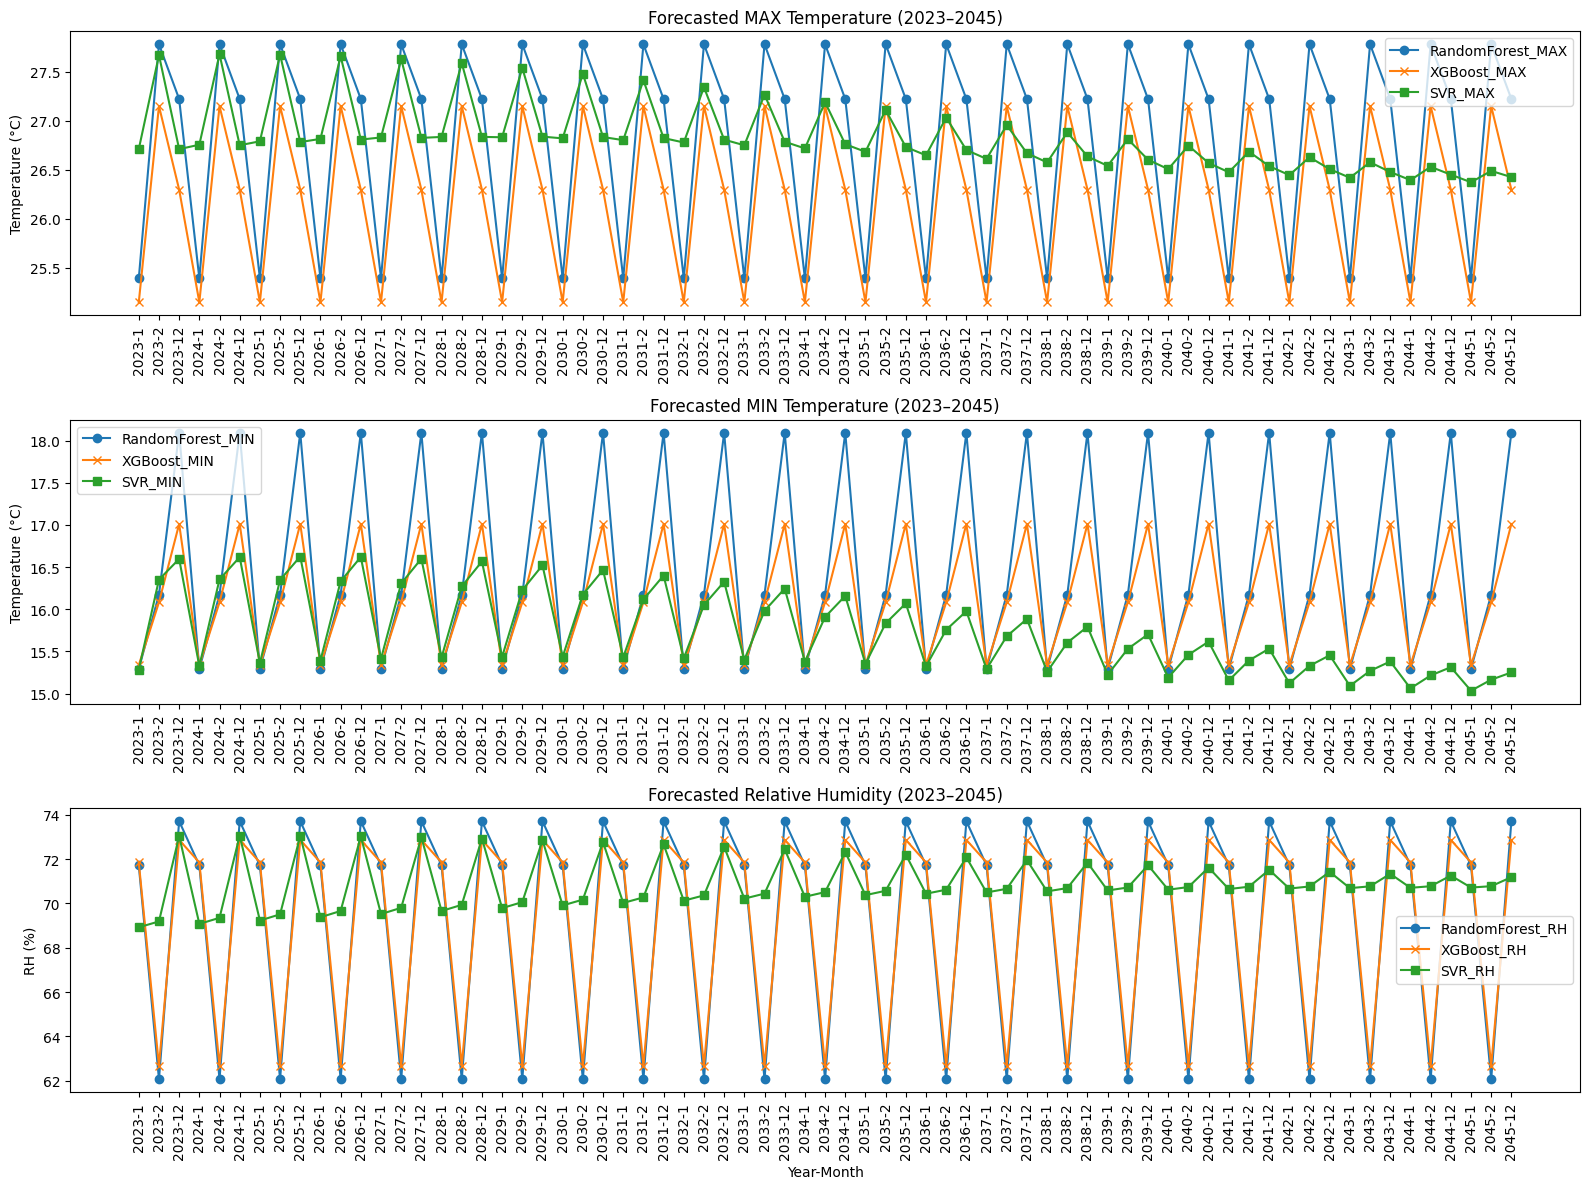

In [23]:
import matplotlib.pyplot as plt

# Generate combined "Year-Month" label for X-axis
forecast_df["YearMonth"] = forecast_df["YEAR"].astype(str) + "-" + forecast_df["MONTH"].astype(str)

# Set figure size
plt.figure(figsize=(16, 12))

# Plot 1: MAX Temperature
plt.subplot(3, 1, 1)
plt.plot(forecast_df["YearMonth"], forecast_df["RandomForest_MAX"], label="RandomForest_MAX", marker='o')
plt.plot(forecast_df["YearMonth"], forecast_df["XGBoost_MAX"], label="XGBoost_MAX", marker='x')
plt.plot(forecast_df["YearMonth"], forecast_df["SVR_MAX"], label="SVR_MAX", marker='s')
plt.title("Forecasted MAX Temperature (2023–2045)")
plt.ylabel("Temperature (°C)")
plt.xticks(rotation=90)
plt.legend()

# Plot 2: MIN Temperature
plt.subplot(3, 1, 2)
plt.plot(forecast_df["YearMonth"], forecast_df["RandomForest_MIN"], label="RandomForest_MIN", marker='o')
plt.plot(forecast_df["YearMonth"], forecast_df["XGBoost_MIN"], label="XGBoost_MIN", marker='x')
plt.plot(forecast_df["YearMonth"], forecast_df["SVR_MIN"], label="SVR_MIN", marker='s')
plt.title("Forecasted MIN Temperature (2023–2045)")
plt.ylabel("Temperature (°C)")
plt.xticks(rotation=90)
plt.legend()

# Plot 3: Relative Humidity
plt.subplot(3, 1, 3)
plt.plot(forecast_df["YearMonth"], forecast_df["RandomForest_RH"], label="RandomForest_RH", marker='o')
plt.plot(forecast_df["YearMonth"], forecast_df["XGBoost_RH"], label="XGBoost_RH", marker='x')
plt.plot(forecast_df["YearMonth"], forecast_df["SVR_RH"], label="SVR_RH", marker='s')
plt.title("Forecasted Relative Humidity (2023–2045)")
plt.ylabel("RH (%)")
plt.xlabel("Year-Month")
plt.xticks(rotation=90)
plt.legend()

plt.tight_layout()
plt.show()
